In [1]:
%load_ext autoreload
%autoreload 2

# Feature pre-pro for autoencoders

In [2]:
import pandas as pd

ratings = pd.read_csv('../Data/df_filtered.csv')

ratings[ratings.userId == 0]

,Unnamed: 0,userId,movieId,rating,imdbId


In [3]:
import pandas as pd

features = pd.read_csv('../movie_metadata.csv')
features.columns

Index(['Unnamed: 0', 'imdb_id', 'title', 'budget', 'genres_cmu', 'languages',
       'original_language', 'spoken_languages', 'countries',
       'production_companies', 'plot_summary', 'overview', 'tagline',
       'keywords', 'popularity', 'vote_average', 'vote_count', 'cast', 'adult',
       'belongs_to_collection', 'box_office_clean', 'release_date_clean',
       'runtime_clean', 'director', 'day', 'month', 'year'],
      dtype='object')

In [4]:
features[['title', 'imdb_id']].to_csv('movie_names.csv')

In [5]:
features['title'][1418]

'Batman'

In [6]:
from ast import literal_eval

features['keywords'] = features['keywords'].apply(literal_eval)

In [7]:
import numpy as np

def one_hot_encode(df, column_name, prefix, keeponly=100):
    all_cat = {}
    for cat in df[column_name]:

        if isinstance(cat, str):
            cat = [el.strip() for el in cat.split(',')]
        
        if not isinstance(cat, list):
            continue
        for el in cat:
            if el not in all_cat:
                all_cat[el] = 0        
            all_cat[el] += 1
    
    sorted_cat = {k: v for k, v in sorted(all_cat.items(), reverse=True, key=lambda item: item[1])}
    
    all_cat = {v[0]: v[1] for v in (list(sorted_cat.items())[:keeponly])}


    print(f' The dataframe has {len(all_cat)} different categories of {column_name}. Let\' one hot encode !')
    columns = []

    for cat in all_cat:
        columns.append(pd.DataFrame({f'{prefix}_{cat}': df[column_name].apply(lambda x: 1 if (not isinstance(x, float) and cat in x) else 0)}))
    
    return all_cat, pd.concat([df, *columns], axis=1)

df = features.copy(deep=True)
#all_countries, df = one_hot_encode(df, 'countries', 'country')
all_keywords, df = one_hot_encode(df, 'keywords', 'keyword', 300)
#all_languages, df = one_hot_encode(df, 'languages', 'language')
all_languages, df = one_hot_encode(df, 'original_language', 'origin_lang')
all_genres, df = one_hot_encode(df, 'genres_cmu', 'genre')
df.columns

 The dataframe has 300 different categories of keywords. Let' one hot encode !
 The dataframe has 77 different categories of original_language. Let' one hot encode !
 The dataframe has 100 different categories of genres_cmu. Let' one hot encode !


Index(['Unnamed: 0', 'imdb_id', 'title', 'budget', 'genres_cmu', 'languages',
       'original_language', 'spoken_languages', 'countries',
       'production_companies',
       ...
       'genre_Fantasy Comedy', 'genre_Political thriller', 'genre_Zombie Film',
       'genre_Courtroom Drama', 'genre_Fantasy Adventure',
       'genre_Domestic Comedy', 'genre_Experimental film',
       'genre_Computer Animation', 'genre_Comedy of Errors', 'genre_Erotica'],
      dtype='object', length=504)

In [8]:
def normalize_without_nan(df, column_name, nan_val=None, clip=None):
    mask = df[column_name].isna()
    if nan_val is not None:
        mask = mask | (df[column_name] == nan_val)
    mask = ~mask

    
    col = df.loc[mask, column_name]


    if clip is not None:
        col = np.clip(col, np.mean(col) - clip* np.std(col), np.mean(col) + clip * np.std(col))

    df.loc[mask, column_name] = ( col - col.mean()) / col.std()

    df.fillna({column_name: 0}, inplace=True)

    return df[column_name]

df['box_office_normalized'] = np.log(df['box_office_clean'].replace(0, 1))
df['box_office_normalized'] = normalize_without_nan(df, 'box_office_normalized', clip=5)
df['year_normalized'] = normalize_without_nan(df, 'year', 0, clip=5)
df['runtime_normalized'] = normalize_without_nan(df, 'runtime_clean', clip=5)

/tmp/ipykernel_107629/972312380.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['box_office_normalized'] = np.log(df['box_office_clean'].replace(0, 1))
/tmp/ipykernel_107629/972312380.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.58021779 -2.05541226  0.4128762  ... -1.92990606  0.83123017
  0.99857176]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, column_name] = ( col - col.mean()) / col.std()
/tmp/ipykernel_107629/972312380.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

In [9]:

# Create final feature matrix
feature_columns = (
    [f'genre_{genre}' for genre in all_genres] +
    #[f'country_{country}' for country in all_countries] +
    [f'origin_lang_{language}' for language in all_languages] +
    [f'keyword_{keyword}' for keyword in all_keywords] +
    ['runtime_normalized', 'box_office_normalized'] +
    ['year_normalized']
)

# Create feature matrix
X = df[feature_columns]
print(f'Numer of na : {np.isnan(X).sum().sum()}')

# Print some information about the features
print("Feature matrix shape:", X.shape)

df['year'] = features['year']

Numer of na : 0
Feature matrix shape: (27329, 480)


In [10]:
import torch

X_tensor = torch.Tensor(X.values)


In [177]:
torch.save(X_tensor, 'torch_tensor.pt', )

# Model

In [1]:
from autoencoder import SparseMovieAutoencoder


## Load previous

In [12]:
input_dim = X_tensor.shape[1]  # number of features after one-hot encoding
encoding_dim = 50 # this is a hyperparameter you can tune
sae = SparseMovieAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim, sparsity_param= 0.01, beta=0.01)

sae.load_state_dict(torch.load('model_current', weights_only=True))
sae.eval()

SparseMovieAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=480, out_features=50, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=480, bias=True)
    (1): Sigmoid()
  )
)

In [14]:
encodings, _ = sae(X_tensor)

In [21]:
np.save('SAE_embedding.npy', encodings.detach().numpy())

In [30]:
mapping_SAE = {int(imdb[2:]): id for id, imdb in enumerate(features['imdb_id'])}
reverse_mapping_SAE = {key: value for value, key in mapping_SAE.items()}
np.save('mapping_SAE.npy', mapping_SAE)
np.save('reverse_mapping_SAE.npy', reverse_mapping_SAE)

In [75]:
# Example to get recommendations

from sklearn.metrics.pairwise import cosine_similarity



imdbid = ['tt0114709', 'tt0126029']
encodings = np.load('SAE_embedding.npy')

similarities = np.zeros(encodings.shape[0])

for movie in imdbid:

    id = mapping_SAE[int(movie[2:])]

    embedding = encodings[id].reshape(1,-1)

    similarities += cosine_similarity(encodings, embedding).ravel()

    similarities[id] = float('-inf')

similar_indices = np.argsort(similarities)[::-1]
print(similar_indices[:5])
recommendations = [reverse_mapping_SAE[rec_id] for rec_id in similar_indices[:5]]

print(recommendations)

[18011 14823 11136   644 26507]
[120363, 116683, 198781, 101329, 117705]


## Retrain model

In [178]:
def analyze_encodings(encodings):
    """Analyze encoding statistics"""
    with torch.no_grad():
        # Move to CPU for analysis
        encodings_cpu = encodings.cpu()
        
        # Calculate sparsity ratio (proportion of near-zero values)
        sparsity_threshold = 1e-3
        sparsity_ratio = (torch.abs(encodings_cpu) < sparsity_threshold).float().mean().item()
        
        # Calculate average activation
        avg_activation = torch.mean(torch.abs(encodings_cpu)).item()
        
        # Calculate standard deviation across features
        encoding_std = torch.std(encodings_cpu, dim=0).mean().item()
        
        return sparsity_ratio, avg_activation, encoding_std


In [186]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from autoencoder import SparseMovieAutoencoder
import torch.nn as nn


input_dim = X_tensor.shape[1]  # number of features after one-hot encoding
encoding_dim = 500 # this is a hyperparameter you can tune
sae = SparseMovieAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim, sparsity_param= 0.01, beta=0.01)

# Create a simple DataLoader
dataset = TensorDataset(X_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Train the model
optimizer = torch.optim.Adam(sae.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
reconstruction_criterion = nn.MSELoss()

# Training loop
training_history = {
        'total_loss': [],
        'reconstruction_loss': [],
        'sparsity_loss': [],
        'avg_activation': [],
        'sparsity_ratio': [],
        'encoding_std': []
    }

# Training loop
print("Starting training...")
for epoch in range(100):
    total_loss = 0
    recon_loss = 0
    sparse_loss = 0
    epoch_encodings = []
    
    for batch in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        encodings, reconstructions = sae(batch[0])
        epoch_encodings.append(encodings.detach())
        
        # Calculate losses
        reconstruction_loss = reconstruction_criterion(reconstructions, batch[0])
        sparsity_loss = sae.get_sparsity_loss(encodings)
        loss = reconstruction_loss + sae.beta * sparsity_loss

        # Inside training loop, before loss.backward()
        if torch.isnan(loss):
            print(f"NaN detected!")
            print(f"Reconstruction loss: {reconstruction_loss.item()}")
            print(f"Sparsity loss: {sparsity_loss.item()}")
            print(f"Encoding stats - min: {encodings.min()}, max: {encodings.max()}, mean: {encodings.mean()}")
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        recon_loss += reconstruction_loss.item()
        sparse_loss += sparsity_loss.item()
    
    # Combine all batch encodings
    epoch_encodings = torch.cat(epoch_encodings, dim=0)
    sparsity_ratio, avg_activation, encoding_std = analyze_encodings(epoch_encodings)
    
    # Store metrics
    training_history['total_loss'].append(total_loss / len(train_loader))
    training_history['reconstruction_loss'].append(recon_loss / len(train_loader))
    training_history['sparsity_loss'].append(sparse_loss / len(train_loader))
    training_history['sparsity_ratio'].append(sparsity_ratio)
    training_history['avg_activation'].append(avg_activation)
    training_history['encoding_std'].append(encoding_std)
    
    # Print progress
    print(f"Epoch {epoch}: Loss={total_loss/len(train_loader):.4f}, "
            f"Sparsity Ratio={sparsity_ratio:.4f}, "
            f"Avg Activation={avg_activation:.4f}")

Starting training...
Epoch 0: Loss=0.0690, Sparsity Ratio=0.3091, Avg Activation=0.0215
Epoch 1: Loss=0.0438, Sparsity Ratio=0.4899, Avg Activation=0.0177
Epoch 2: Loss=0.0351, Sparsity Ratio=0.6289, Avg Activation=0.0134
Epoch 3: Loss=0.0317, Sparsity Ratio=0.6618, Avg Activation=0.0123
Epoch 4: Loss=0.0290, Sparsity Ratio=0.6536, Avg Activation=0.0119
Epoch 5: Loss=0.0267, Sparsity Ratio=0.6498, Avg Activation=0.0114
Epoch 6: Loss=0.0242, Sparsity Ratio=0.6483, Avg Activation=0.0111
Epoch 7: Loss=0.0243, Sparsity Ratio=0.6473, Avg Activation=0.0110
Epoch 8: Loss=0.0243, Sparsity Ratio=0.6450, Avg Activation=0.0110
Epoch 9: Loss=0.0236, Sparsity Ratio=0.6412, Avg Activation=0.0110
Epoch 10: Loss=0.0239, Sparsity Ratio=0.6422, Avg Activation=0.0110
Epoch 11: Loss=0.0243, Sparsity Ratio=0.6455, Avg Activation=0.0110


KeyboardInterrupt: 

# Feature intepretation + Visu

In [198]:
def interpret_features(model, X_tensor, df, feature_names, neuron=None):
    with torch.no_grad():
        # Get encodings
        encodings, _ = model(X_tensor)
        
        if not isinstance(neuron, list):
            neuron = range(encodings.shape[1])

        neurons_list = []

        # For each neuron in the encoding
        for neuron_idx in neuron:

            # Get movies that activate this neuron the most
            activation = encodings[:, neuron_idx]
            top_movies = activation.argsort(descending=True)[:5]
            
            #print(f"\nNeuron {neuron_idx}:")
            #print("Top activating movies:")
            #for idx in top_movies:
            #    print(f"- {df.iloc[int(idx)]['title']} "
            #          f"(activation: {activation[int(idx)]:.3f})")

            # Find feature correlation
            correlations = []
            for i, feature in enumerate(feature_names):
                corr = torch.corrcoef(
                    torch.stack([activation, X_tensor[:, i]])
                )[0,1].item()
                correlations.append((feature, corr))

            neurons_list.append([top_movies, correlations])
            
            # Print top correlated features
            #print("Top correlated features:")
            #for feature, corr in sorted(correlations, 
            #                          key=lambda x: (x[1]), 
            #                          reverse=True)[:5]:
            #    print(f"- {feature}: {corr:.3f}")
    return neurons_list

# Use it
neurons_info = interpret_features(sae, X_tensor, features, X.columns)

In [262]:
neurons_concise = []
for info in neurons_info:
    langs = []
    for i in info[1]:
        if 'lang_' in i[0]:
            langs.append({i[0]: i[1]})

    neurons_concise.append([list(df.iloc[list(info[0])]['imdb_id']),
                             sorted(info[1], key=lambda x: abs(x[1]), reverse=True)[:10], langs])

In [263]:
import json

import json

# Assuming neurons_concise contains your title-activation pairs
with open('neurons_data.json', 'w') as f:
    json.dump(
        [{"titles": title, "activations": {k:d for k, d in value}, "countries": countries} for title, value, countries in neurons_concise],
        f,
        indent=2  # This makes the JSON file readable with nice formatting
    )

In [264]:
with open('neurons_data.json', 'r') as f:
    print(json.load(f)[0])

{'titles': ['tt0145033', 'tt0485241', 'tt0067354', 'tt0327169', 'tt0078753'], 'activations': {'genre_Thriller': -0.2072601467370987, 'genre_Action/Adventure': -0.19817481935024261, 'genre_Crime Fiction': -0.18694765865802765, 'genre_Adventure': -0.18284004926681519, 'genre_Comedy': -0.17430910468101501, 'origin_lang_it': 0.17323718965053558, 'origin_lang_en': -0.16520941257476807, 'genre_Action': -0.1592087298631668, 'box_office_normalized': -0.14484696090221405, 'keyword_independent film': -0.13827075064182281}, 'countries': [{'origin_lang_ab': -0.004183308221399784}, {'origin_lang_af': -0.003384246490895748}, {'origin_lang_am': 0.0031041777692735195}, {'origin_lang_ar': 0.03247978165745735}, {'origin_lang_ay': 0.014814906753599644}, {'origin_lang_bg': 0.01936175301671028}, {'origin_lang_bm': 0.019358254969120026}, {'origin_lang_bn': 0.06086805835366249}, {'origin_lang_bo': -0.004786130040884018}, {'origin_lang_bs': -0.0050814091227948666}, {'origin_lang_ca': -0.0004386853543110192}, 

In [235]:
df['original_language'].unique()

array(['en', 'es', 'tr', 'sv', 'it', 'hi', 'pl', 'hu', 'de', 'sr', 'fi',
       'ko', 'fr', 'da', 'ro', 'cn', 'ja', 'pt', 'he', 'nl', 'el', 'mk',
       'ru', 'bs', 'xx', 'cs', 'bo', 'fa', 'no', 'zh', 'te', 'th', 'ta',
       'mr', 'wo', 'sl', 'ar', 'bn', 'ky', 'ay', 'id', 'ml', 'tl', 'ka',
       'hr', 'ur', 'is', 'mn', 'tg', 'rw', 'bm', 'sq', nan, 'vi', 'ab',
       'ku', 'sh', 'sk', 'ps', 'nb', 'bg', 'ca', 'eo', 'lt', 'et', 'fy',
       'uk', 'zu', 'la', 'ms', 'af', 'sm', 'lv', 'am', 'cy', 'eu', 'si',
       'jv'], dtype=object)

In [187]:
with torch.no_grad():
    encodings, _ = sae(X_tensor)
    movie_embeddings = encodings.numpy()

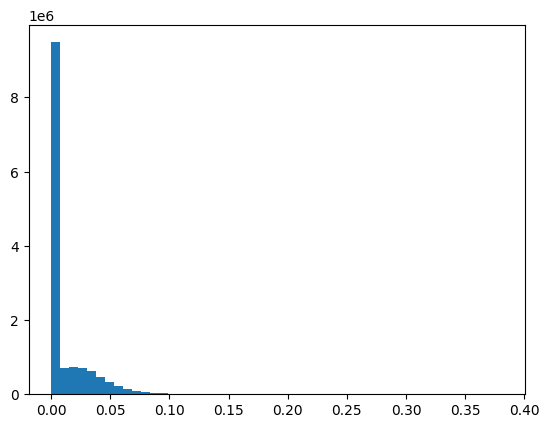

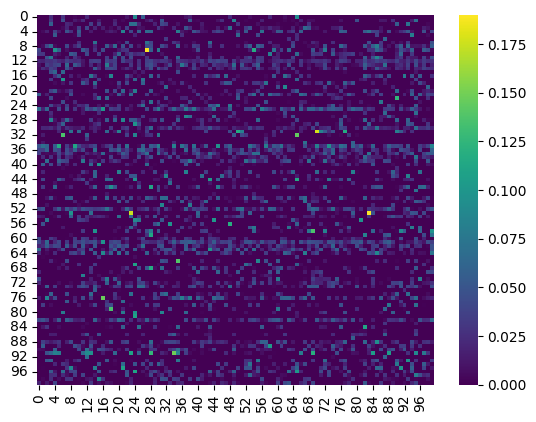

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.hist(encodings.flatten(), bins=50)
plt.show()
sns.heatmap(encodings[:100, :100], cmap='viridis')
plt.show()

In [189]:
countries_of_interest = ['United States of America', 'Japan', 'France', 'Switzerland']

current_year = 2024  # or df['year'].max()

recent_mask = df['year'] >= 2000
somewhat_old_mask = (df['year'] >= 2000) & (df['year'] < 1960)
old_mask = df['year'] < 1960

mask = np.zeros((df.shape[0],1))

n = 30

# Filter for movies that have EXACTLY one of these countries (no others)
indices = []
countries = []
for country in countries_of_interest:
    country_movies = df[df[f'countries'] == country]
    
    m = len(indices)
    indices.extend(
        country_movies[recent_mask].nlargest(n, 'box_office_normalized').index.tolist())
    countries.extend((len(indices) - m) * [country])
    if country == 'Switzerland' or country == 'Japan':
        continue
    m = len(indices)

    indices.extend(
        country_movies[somewhat_old_mask].nlargest(n, 'box_office_normalized').index.tolist())
    countries.extend(n * [country])

    indices.extend(
        country_movies[old_mask].nlargest(n, 'box_office_normalized').index.tolist())
    countries.extend(n * [country])

    countries.extend((len(indices) - m) * [country])

indices = np.array(indices)
countries = np.array(countries)

/tmp/ipykernel_43926/900954121.py:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_43926/900954121.py:28: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_43926/900954121.py:32: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_43926/900954121.py:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_43926/900954121.py:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_43926/900954121.py:28: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_43926/900954121.py:32: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_43926/900954121.py:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [190]:
def get_genre(s):
    keywords = ['Family', 'Thriller', 'Action', 'Short Film', 'Black-and-white', 'Comedy', 'Romance Film', 'Drama']
    for word in keywords:
        if word in s:
            return word

In [195]:
movies_interest = encodings[features.iloc[indices].index]
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE()

reduce = tsne.fit_transform(movies_interest)

plot_df = pd.DataFrame({
    'TSNE_1': reduce[:, 0],
    'TSNE_2': reduce[:, 1],
    'Country': features.iloc[indices]['countries'].apply(lambda x: '' if x == np.nan else (x.split(',')[-1].strip())),
    'Year': features.iloc[indices]['year'],
    'Title': features.iloc[indices]['title'],
    'Box Office': X.iloc[indices]['box_office_normalized'],
    'Genres' : features.iloc[indices]['genres_cmu'].apply(lambda x: get_genre(str(x)))
})
    
min_year = plot_df['Box Office'].min()
max_year = plot_df['Box Office'].max()
plot_df['marker_size'] = ((plot_df['Box Office'] - min_year) / (max_year - min_year) * 45 + 5)
    
    # Create the scatter plot
fig = px.scatter(
    plot_df,
    x='TSNE_1',
    y='TSNE_2',
    color='Genres',
    size='marker_size',
    hover_data=['Title', 'Year'],
    title='Movie Embeddings Visualization',
    labels={
        'TSNE_1': 't-SNE Dimension 1',
        'TSNE_2': 't-SNE Dimension 2'
    }
)

# Update layout for better visualization
fig.update_layout(
    plot_bgcolor='white',
    width=1000,
    height=800,
    legend_title_text='Country',
    showlegend=True,
    hovermode='closest'
)
    
# Update traces
fig.update_traces(
    marker=dict(
        line=dict(width=1, color='DarkSlateGrey')
    ),
    selector=dict(mode='markers')
)


In [356]:
# Convert the DataFrame to a JSON format
plot_data = plot_df.to_dict('records')

# Save to a JSON file
import json
with open('movie_data.json', 'w') as f:
    json.dump(plot_data, f)

In [295]:
id = 7000

choice = list(ratings[ratings.userId == id].sort_values(by='rating', ascending=False)['movieId'])
values = list(ratings[ratings.userId == id].sort_values(by='rating', ascending=False)['rating'])
print(choice)
print(values)
user_rating = {c:r for c,r in zip(choice, values)}

[858, 923, 1266, 1272, 1197, 2006, 1527, 1240, 4920, 4246, 4499, 4106, 2662, 1953, 1961, 1321, 1343, 1608, 1945, 1136, 1210, 4971, 4857, 4803, 4534, 4912, 2528, 2470, 2023, 3897, 3996, 3528, 4784, 4231, 3763, 3111, 2067, 928, 1222, 805, 920, 594, 2301, 2916, 3527, 4798, 2985, 4270, 4639, 4947, 4855, 4972, 2628]
[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0]


In [296]:
import torch.nn.functional as F

movie_embedding = encodings[choice[0]]

actual_order = list(choice[1:])

print(actual_order)

similarities = F.cosine_similarity(encodings, movie_embedding.unsqueeze(0))
similarities[0] = float('-inf')
similar_indices = similarities.argsort(descending=True)

#similar_indices[np.sort(np.array([np.where(similar_indices == a)[0][0] for a in actual_order]))] 


[923, 1266, 1272, 1197, 2006, 1527, 1240, 4920, 4246, 4499, 4106, 2662, 1953, 1961, 1321, 1343, 1608, 1945, 1136, 1210, 4971, 4857, 4803, 4534, 4912, 2528, 2470, 2023, 3897, 3996, 3528, 4784, 4231, 3763, 3111, 2067, 928, 1222, 805, 920, 594, 2301, 2916, 3527, 4798, 2985, 4270, 4639, 4947, 4855, 4972, 2628]


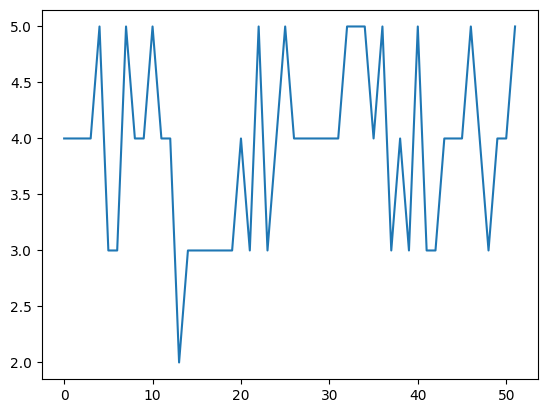

In [297]:
rec_order = []
for a in actual_order:
    idx = np.where(similar_indices == a)[0]
    if len(idx) > 0:
        rec_order.append(idx[0])

rec_order = similar_indices[sorted(rec_order)].numpy()
ratings_associated = []
for el in rec_order:
    ratings_associated.append(user_rating[el])
ratings_associated = np.array(ratings_associated)
plt.plot(ratings_associated)

In [197]:
import numpy as np
from scipy.stats import kendalltau, spearmanr

def evaluate_ranking(actual_ids, predicted_ids):
    """
    Evaluate the similarity between two rankings of the same elements.
    
    Parameters:
    actual_ids (list): Ground truth ordering of items
    predicted_ids (list): Predicted ordering of the same items
    
    Returns:
    dict: Dictionary containing various ranking correlation metrics
    """
    # Verify that we have the same elements
    if set(actual_ids) != set(predicted_ids):
        raise ValueError("Both lists must contain the same elements")
    
    # Create position mappings for each element
    actual_positions = {id: pos for pos, id in enumerate(actual_ids)}
    
    # Calculate position-based distance metrics
    def calculate_displacement():
        total_displacement = 0
        max_displacement = 0
        
        for pred_pos, id in enumerate(predicted_ids):
            actual_pos = actual_positions[id]
            displacement = abs(pred_pos - actual_pos)
            total_displacement += displacement
            max_displacement = max(max_displacement, displacement)
            
        avg_displacement = total_displacement / len(actual_ids)
        return avg_displacement, max_displacement
    
    # Spearman's rank correlation
    spearman_corr, _ = spearmanr(actual_ids, predicted_ids)
    
    # Kendall's Tau rank correlation
    kendall_corr, _ = kendalltau(actual_ids, predicted_ids)
    
    # Calculate normalized discounted cumulative gain (NDCG)
    def calculate_ndcg():
        # Create relevance scores based on position (higher score for higher rank)
        max_pos = len(actual_ids)
        relevance_scores = {id: max_pos - pos for pos, id in enumerate(actual_ids)}
        
        # Calculate DCG
        dcg = 0
        idcg = 0
        for pos, (pred_id, actual_id) in enumerate(zip(predicted_ids, actual_ids), 1):
            # Add 1 to position to avoid log(1) = 0
            dcg += relevance_scores[pred_id] / np.log2(pos + 1)
            idcg += relevance_scores[actual_id] / np.log2(pos + 1)
            
        return dcg / idcg if idcg != 0 else 0
    
    avg_displacement, max_displacement = calculate_displacement()
    ndcg = calculate_ndcg()
    
    return {
        'spearman_correlation': spearman_corr,
        'kendall_tau': kendall_corr,
        'average_displacement': avg_displacement,
        'maximum_displacement': max_displacement,
        'ndcg': ndcg
    }

# Example usage
actual = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
predicted = [1, 3, 2, 5, 4, 7, 6, 9, 8, 10]

metrics = evaluate_ranking(actual, predicted)
metrics

{'spearman_correlation': np.float64(0.9515151515151514),
 'kendall_tau': np.float64(0.8222222222222221),
 'average_displacement': 0.8,
 'maximum_displacement': 1,
 'ndcg': np.float64(0.9929232641600197)}

In [166]:
X.describe()

,genre_Drama,genre_Comedy,genre_Thriller,genre_Romance Film,genre_Action,genre_World cinema,genre_Crime Fiction,genre_Indie,genre_Action/Adventure,genre_Horror,...,keyword_space travel,keyword_virgin,keyword_outlaw,keyword_twins,keyword_india,keyword_astronaut,keyword_based on video game,runtime_normalized,box_office_normalized,year_normalized
count,27329.000000,27329.000000,27329.000000,27329.000000,27329.000000,27329.000000,27329.000000,27329.000000,27329.000000,27329.000000,...,27329.000000,27329.000000,27329.000000,27329.000000,27329.000000,27329.000000,27329.000000,2.732900e+04,2.732900e+04,2.732900e+04
mean,0.497018,0.324161,0.197775,0.177065,0.178528,0.146072,0.130740,0.116872,0.115738,0.108749,...,0.002049,0.002049,0.002049,0.002049,0.002013,0.002013,0.002013,-1.091983e-17,3.769940e-18,-1.048303e-15
std,0.500000,0.468069,0.398329,0.381730,0.382964,0.353185,0.337122,0.321274,0.319916,0.311330,...,0.045221,0.045221,0.045221,0.045221,0.044817,0.044817,0.044817,7.268329e-01,7.771011e-01,7.762059e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.814150e+00,-2.052177e+00,-3.979841e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.264711e-01,-6.154002e-01,0.000000e+00
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,5.383824e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.968500e+01,2.567100e+00,1.207749e+00


In [199]:
import torch.nn.functional as F

def get_recommendations(movie_name, n=5):


    # Get the index of the movie
    if isinstance(movie_name, int):
        movie_idx = features[features['wikipedia_movie_id'] == movie_name].index[0]
    else:
        movie_idx = features[features['movie_name'] == movie_name].index[0]
    
    # Get its embedding (as tensor)
    movie_embedding = encodings[movie_idx]

    # print(movie_embedding)
    
    # Calculate similarities with all other movies using PyTorch
    similarities = F.cosine_similarity(encodings, movie_embedding.unsqueeze(0))
    
    # Get top similar movies (excluding itself)
    # Set similarity with itself to negative infinity to exclude it
    similarities[movie_idx] = float('-inf')
    similar_indices = similarities.argsort(descending=True)[:n]
    
    return features.iloc[similar_indices.numpy()][['movie_name', 'year', 'genres']]

# Example usage
recommendations = get_recommendations("WALL-E")
print(recommendations)

                                              movie_name    year  \
65985                                       Tron: Legacy  2010.0   
23381  The Adventures of Tintin: The Secret of the Un...  2011.0   
62864                                         Happy Feet  2006.0   
18345                                     Chicken Little  2005.0   
34792                                          Planet 51  2009.0   

                                                  genres  
65985  [Thriller, Science Fiction, Adventure, Compute...  
23381  [Adventure, Computer Animation, Animation, Mys...  
62864  [Adventure, Children's/Family, Computer Animat...  
18345  [Science Fiction, Adventure, Computer Animatio...  
34792  [Science Fiction, Adventure, Computer Animatio...  


In [501]:
np.mean(encodings.numpy() < 0.01, axis=1)

array([0.890625  , 0.515625  , 0.07421875, ..., 0.42578125, 0.671875  ,
       0.62109375])

Total neurons: 512
Average active neurons per movie: 0.04
Neurons with significant average activation: 0


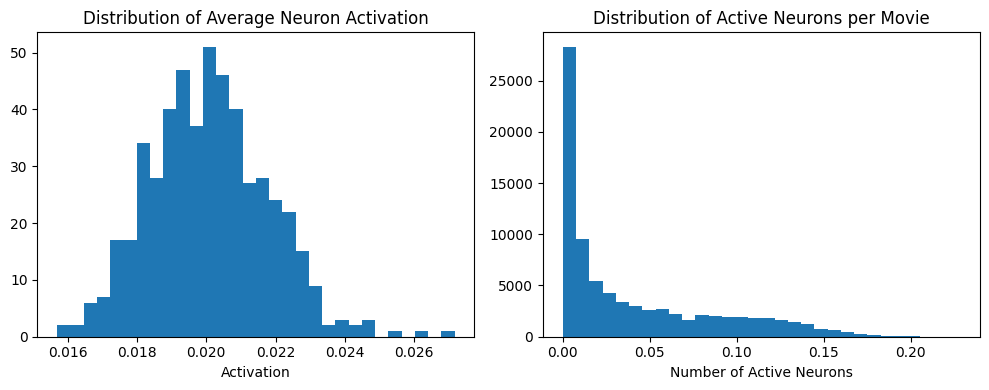

In [200]:
import matplotlib.pyplot as plt

def analyze_sparsity(model, X_tensor):
    with torch.no_grad():
        encodings, _ = model(X_tensor)
        
        # Calculate average activation of each neuron
        avg_activation = encodings.mean(dim=0)
        
        # Calculate sparsity metrics
        active_neurons = (avg_activation > 0.05).sum()  # neurons with significant activation
        sparsity_per_sample = (encodings > 0.05).float().mean(dim=1)  # active neurons per movie
        
        print(f"Total neurons: {encodings.shape[1]}")
        print(f"Average active neurons per movie: {sparsity_per_sample.mean():.2f}")
        print(f"Neurons with significant average activation: {active_neurons}")
        
        # Visualize activation distribution
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.hist(avg_activation.numpy(), bins=30)
        plt.title('Distribution of Average Neuron Activation')
        plt.xlabel('Activation')
        
        plt.subplot(1, 2, 2)
        plt.hist(sparsity_per_sample.numpy(), bins=30)
        plt.title('Distribution of Active Neurons per Movie')
        plt.xlabel('Number of Active Neurons')
        plt.tight_layout()
        plt.show()

# Use it
analyze_sparsity(sae, X_tensor)

In [299]:
features.columns[-30:]

Index(['language_Frisian, Western Language', 'language_Hariyani',
       'language_Serbian language', 'language_Romanian Language',
       'language_Swedish Language', 'language_Haryanvi Language',
       'language_Egyptian Arabic', 'language_Napoletano-Calabrese Language',
       'language_Bosnian language', 'language_Navajo Language',
       'language_Cantonese', 'language_Chadian Arabic', 'language_Hainanese',
       'language_Icelandic Language', 'language_Malay Language',
       'language_Apache, Western Language', 'language_Lithuanian language',
       'language_Cree language', 'language_Tamil Language',
       'language_Picard Language', 'language_Classical Arabic',
       'language_Italian Language', 'language_Turkish Language',
       'language_Welsh Language', 'language_Friulian Language',
       'language_Korean Language', 'language_Hawaiian language',
       'language_Urdu Language', 'language_France',
       'language_German Language'],
      dtype='object')

In [302]:
X.columns[list(map(lambda x: 'genre' in x, list(X.columns)))]

Index(['country_Iceland', 'country_Greece', 'country_Austria',
       'country_Turkmenistan', 'country_Belgium', 'country_Thailand',
       'country_Azerbaijan', 'country_Burkina Faso',
       'country_Kingdom of Great Britain', 'country_Georgian SSR',
       ...
       'country_Israel', 'country_Nigeria', 'country_Bhutan',
       'country_Hong Kong', 'country_Egypt', 'country_Korea', 'country_Brazil',
       'country_France', 'country_Costa Rica', 'country_German Language'],
      dtype='object', length=147)

In [162]:
(df['runtime_normalized'] > (df['runtime_normalized']).std() * 5).sum()

np.int64(76)

In [157]:

neuron = 5

activation = encodings[:, neuron]
top_movies = activation.argsort(descending=True)[:20]

print(f"\nNeuron {neuron}:")
print("Top activating movies:")
for idx in top_movies:
    print(f"- {df.iloc[int(idx)]['title']} ")
# Find feature correlation
correlations = []
for i, feature in enumerate(X.columns[list(map(lambda x: True or 'genre' in x, list(X.columns)))]):
    corr = torch.corrcoef(
        torch.stack([activation, X_tensor[:, i]])
    )[0,1].item()
    correlations.append((feature, corr))

# Print top correlated features
print("Top correlated features:")
for feature, corr in sorted(correlations, 
                            key=lambda x: abs(x[1]), 
                            reverse=True):
    print(f"- {feature}: {corr:.3f}")


Neuron 5:
Top activating movies:
- New York: A Documentary Film 
- The Immigrant 
- Hitler: A Film from Germany 
- Skyscraper Souls 
- The Bachelor Father 
- Seven Years Bad Luck 
- If I Had a Million 
- Movie Crazy 
- Tie Xi Qu: West of the Tracks 
- The Little Foxes 
- The Bohemian Girl 
- Captain January 
- Empire 
- Show Boat 
- The Cocoanuts 
- Forsaking All Others 
- A Farewell to Arms 
- Tales of Manhattan 
- Man on the Flying Trapeze 
- A Successful Calamity 
Top correlated features:
- genre_Black-and-white: 0.627
- year_normalized: -0.600
- genre_Adventure: -0.381
- genre_Action: -0.313
- genre_Action/Adventure: -0.307
- genre_Thriller: -0.248
- genre_World cinema: -0.237
- genre_Drama: 0.215
- box_office_normalized: -0.206
- genre_Indie: -0.202
- keyword_independent film: -0.174
- genre_Film noir: 0.173
- genre_Science Fiction: -0.171
- genre_Horror: -0.171
- genre_Comedy: 0.158
- genre_Fantasy: -0.157
- genre_Silent film: 0.155
- origin_lang_en: 0.149
- genre_Martial Arts F